In [1]:
import numpy as np
from src.io.psee_loader import PSEELoader
import numpy as np
#from src.metrics.coco_eval import evaluate_detection
from src.io.box_loading import reformat_boxes
from src.io.box_filtering import filter_boxes

RESULT_FILE_PATHS = ["gen1.npy"]
GT_FILE_PATHS = ["gen1.npy"]

result_boxes_list = [np.load(p) for p in RESULT_FILE_PATHS]
gt_boxes_list = [np.load(p) for p in GT_FILE_PATHS]

# For backward-compatibility
result_boxes_list = [reformat_boxes(p) for p in result_boxes_list]
gt_boxes_list = [reformat_boxes(p) for p in gt_boxes_list]

# For fair comparison with paper results
gt_boxes_list = map(filter_boxes, gt_boxes_list)
result_boxes_list = map(filter_boxes, result_boxes_list)

#evaluate_detection(gt_boxes_list, result_boxes_list)

# Opening a file

In [4]:
from src.io.box_loading import reformat_boxes
from src.io.box_filtering import filter_boxes

# open a file
video = PSEELoader("gen1_td.dat")
print(video)  # show some metadata
video.event_count()  # number of events in the file
video.total_time()  # duration of the file in mus

boox = np.load('gen1.npy')
boox = reformat_boxes(boox)
boox = filter_boxes(boox, skip_ts=0, min_box_diag=30, min_box_side=10)

# print(np.unique(boox['t']))

print(boox[boox['t'] <= 249999])
events = video.load_n_events(video.event_count())
print(len(events[events['t'] <= 249999]))

# print(.dtype)

ev = np.empty(len(events), dtype = np.dtype([("x", np.int16), ("y", np.int16), ("p", bool), ("t", np.int64)]))
ev['x'] = events['x']
ev['y'] = events['y']
ev['t'] = events['t']
ev['p'] = events['p']
mask = (ev['t'] > 9749999) & (ev['t'] <= 9999999)
ev = ev[mask]
print(ev['t'].max(), ev['t'].min())
ev['t'] = ev['t'] - ev['t'].min() # put everything to 0
print(ev['t'].max(), ev['t'].min())
# np.save('example.npy', ev)

PSEELoader:
-----------
Event Type: Event2D
Event Size: 8 bytes
Event Count: 55954538
Duration: 59.999942 s 
-----------

[(249999, 125., 91.,  21., 39., 1, 530, 1.)
 (249999, -21., 73., 110., 72., 0, 531, 1.)
 (249999, 202., 90.,  23., 45., 1, 532, 1.)]
532135
9999995 9750000
249995 0


In [ ]:
# open a file
video = PSEELoader("gen1_td.dat")
print(video)  # show some metadata
video.event_count()  # number of events in the file
video.total_time()  # duration of the file in mus

boox = np.load('gen1.npy')
print(boox[boox['ts'] <= 249999])
events = video.load_n_events(video.event_count())


# print(.dtype)

PSEELoader:
-----------
Event Type: Event2D
Event Size: 8 bytes
Event Count: 55954538
Duration: 59.999942 s 
-----------

[(249999, 125., 91.,  21., 39., 1, 1., 530)
 (249999, -21., 73., 110., 72., 0, 1., 531)
 (249999, 202., 90.,  23., 45., 1, 1., 532)]


# Event Format

In [5]:
# let's read some Events , there are two ways by number of events or by time slices
events = video.load_n_events(10)  # this loads the 10 next events
events

array([(0,  16,  7, 0), (0, 156,  7, 0), (0, 243,  7, 0), (2,  62, 33, 0),
       (2,  69, 33, 0), (2, 152, 33, 0), (2, 239, 33, 1), (2, 251, 33, 1),
       (3,  14, 32, 1), (3, 255, 32, 0)],
      dtype=[('t', '<u4'), ('x', '<u2'), ('y', '<u2'), ('p', 'u1')])

Events are in a numpy [structured array](https://docs.scipy.org/doc/numpy/user/basics.rec.html)

In [6]:
# TLDR : we can access different fields in this one dimensional array
print(events['t'])  # this shows only the timestamps of events
# for instance to count the events of positive polarity you can do :
np.sum(events['p'] > 0)

[0 0 0 2 2 2 2 2 3 3]


3

In [7]:
# let's randomly drop some events
np.random.choice(events, len(events)//2)

array([(0, 243,  7, 0), (3, 255, 32, 0), (0,  16,  7, 0), (2,  69, 33, 0),
       (3, 255, 32, 0)],
      dtype=[('t', '<u4'), ('x', '<u2'), ('y', '<u2'), ('p', 'u1')])

In [16]:
# let's now try to read 10ms worth of events
events = video.load_delta_t(10000)
events

array([(   0,  16,   7, 0), (   0, 156,   7, 0), (   0, 243,   7, 0), ...,
       (9996, 283, 111, 0), (9996,  10, 111, 0), (9997, 120, 111, 0)],
      dtype=[('t', '<u4'), ('x', '<u2'), ('y', '<u2'), ('p', 'u1')])

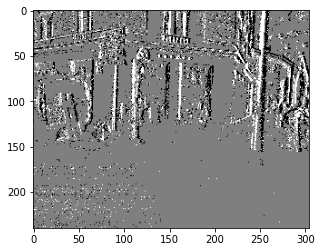

In [17]:
import src.visualize.vis_utils as vu
import matplotlib.pyplot as plt
img = vu.make_binary_histo(events)
plt.imshow(img)
plt.show()

# Iteration

In [9]:
# to iterate through a dataset you can use :
while not video.done:
    # load events and boxes from all files
    events = video.load_delta_t(50000)
    # do something with the events

In [10]:
# once a video is fully read there is no events in it anymore :
print(len(video.load_n_events(1)))

0


In [11]:
# but you can rewind using seek_event or seek_time
video.seek_event(3)  # this goes before the fourth events (index starts at 0)

In [12]:
video.seek_time(10000)  # this goes before the first event after 9999mus

# Bonus

In [13]:
# this functions can be used to read a video backwards for instance
video.seek_time(video.total_time()+1)
delta_t = 100000
for t in np.arange(video.total_time()- delta_t, -delta_t, -delta_t):
    video.seek_time(t)
    events = video.load_delta_t(delta_t)
    # they should be sorted in descending timestamp order !
    events = events[::-1]
    # do some cunning computer vision here.
    pass